# Spoken Language Processing 2022-23

# Lab3 - Dialogue Systems

_Bruno Martins_


This lab assignment will introduce tools and concepts related to the development of dialogue systems, exemplifying also the use of automatic speech recognition and text-to-speech models.

Students will be tasked with the development of a simple (spoken/conversational) question answering system, reusing different models associated to the HuggingFace Transformers library:

* Speech recognition models (e.g., OpenAI Whisper).
* Large language models for natural language understanding and generation (e.g., GPT-2 or Alpaca models).
* Text-to-speech models (e.g., SpeechT5).

The first parts of this notebook will guide students in the use of the tools, while the last part presents the main problem that is to be tackled. Note that the first parts also features intermediate tasks, which students are required to solve.

To complete the project, student groups must deliver in Fenix an updated version of this notebook, featuring the proposed solutions to each task, together with a small PDF report (2 pages) outlining the methods that were developed (you can use the [following Overleaf template](https://www.overleaf.com/latex/templates/interspeech-2023-paper-kit/kzcdqdmkqvbr) for the report).

Students are encouraged to modify examples, incorporate any other techniques, and in general explore any approach that may permit improving the results. Assessment will be based on task completion, creativity in the proposed solutions, and overall accuracy over a benchmark dataset.

### Group identification

Initialize the variable `group_id` with the number that Fenix assigned to your group and `student1_name`, `student1_id`, `student2_name` and `student2_id` with your names and student numbers.

In [ ]:
# YOUR CODE HERE
# raise NotImplementedError()

group_id = 12
student1_name = 'Antonio Vitor'
student1_id = 105429
student2_name = 'Rita Leite'
student2_id = 92646

print(f"Group number: {group_id}")
print(f"Student 1: {student1_name} ({student1_id})")
print(f"Student 2: {student2_name} ({student2_id})")

Group number: 12
Student 1: Antonio Vitor (105429)
Student 2: Rita Leite (92646)


In [ ]:
assert isinstance(group_id, int) and isinstance(student1_id, int) and isinstance(student2_id, int)
assert isinstance(student1_name, str) and isinstance(student2_name, str)
assert (group_id > 0) and (group_id < 40)
assert (student1_id > 60000) and (student1_id < 120000) and (student2_id > 60000) and (student2_id < 120000)

# Python packages

NumPy is a Python library that provides functions to process multidimensional array objects. The NumPy documentation is available [here](https://numpy.org/doc/1.24/).

[Librosa](https://librosa.org/) is a Python package for analyzing and processing audio signals. It provides a wide range of tools for tasks such as loading and manipulating audio files, extracting features from audio signals, and visualizing and playing back audio data.

IPython display is a module in the IPython interactive computing environment that provides a set of functions for displaying various types of media in the Jupyter notebook or other IPython-compatible environments. For example, you can use the display() function to display an object in a notebook cell (for example an audio object).

Matplotlib is a popular Python library that allows users to create a wide range of visualizations using a simple and intuitive syntax.

Huggingface transformers provides APIs and tools to easily download and train state-of-the-art pretrained models based on the Transformer architecture. The documentation is available [here](https://huggingface.co/docs/transformers/index) and, for more details, look at the official [HuggingFace course](https://huggingface.co/course/chapter1/1).

The associated HuggingFace libraries named [datasets](https://huggingface.co/docs/datasets/index) and [evaluate](https://huggingface.co/docs/evaluate/index) respectivly suport the direct access to many well-known datasets and common evaluation metrics used in NLP and speech research.

In [1]:
import os

try:
    import transformers
    import datasets
    import evaluate
    import numpy as np
    import librosa
    import librosa.display
    from IPython.display import Audio
    from matplotlib import pyplot as plt

except:
    print('installing...')
    os.system('pip install -r requirements.txt')

installing...


# Using OpenAI Whisper

Whisper is an exciting new model for Automatic Speech Recognition (ASR), developed by OpenAI and made available through the HuggingFace Transformers library.

The following example illustrates the use of the Whisper model to transcribe a small audio sample taken from the LibriSpeech dataset (which is available through the HuggingFace datasets library).

More detailed information about Whisper, including information on how to fine-tune the model with task-specific data, is available on a [tutorial in the HuggingFace blog](https://huggingface.co/blog/fine-tune-whisper).

In [33]:
import torch
import librosa
from transformers import AutoProcessor, WhisperForConditionalGeneration
from datasets import load_dataset

ds = load_dataset("hf-internal-testing/librispeech_asr_dummy", "clean", split="validation")

processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")

audio = ds[0]["audio"]["array"]
audio = librosa.resample(audio, orig_sr=16000, target_sr=16000) # Resample audio to 16kHz (not needed in the case of this dataset)

inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
input_features = inputs.input_features

display(Audio(audio, rate=16000)) # You are able to hear the audio inputs

generated_ids = model.generate(inputs=input_features)
transcription = processor.batch_decode(generated_ids, max_length=250, skip_special_tokens=True)[0]

print(transcription)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset librispeech_asr_dummy downloaded and prepared to /root/.cache/huggingface/datasets/hf-internal-testing___librispeech_asr_dummy/clean/2.1.0/d3bc4c2bc2078fcde3ad0f0f635862e4c0fef78ba94c4a34c4c250a097af240b. Subsequent calls will reuse this data.


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


 Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel.


Automatic Speech Recognition (ASR) models are frequently evaluated through the Word Error Rate (WER).

The WER is derived from the Levenshtein distance, working at the word level and aligning the recognized word sequence with the reference (spoken) word sequence using dynamic string alignment. The metric can then be computed as:

WER = (S + D + I) / N = (S + D + I) / (S + D + C),

where S is the number of substitutions, D is the number of deletions, I is the number of insertions, C is the number of correct words, and N is the number of words in the reference (N=S+D+C). The WER value indicates the average number of errors per reference word. The lower the value, the better the performance of the ASR system, with a WER of 0 being a perfect score.

The example below illustrates the computation of the WER for two paired examples of a generated sentence versus a reference sentence. The score produced as output is the average value accross the two examples.

In [3]:
from evaluate import load
import numpy as np
wer = load("wer")
predictions = ["this is the prediction", "there is an other sample"]
references = ["this is the reference", "there is another one"]
wer_score = wer.compute(predictions=predictions, references=references)

print(wer_score)

0.5


## Intermediate tasks:

* Collect two small audio samples with your own voice, together with a transcription of the spoken messages. The following [example shows how to record audio from your microphone within a Python notebook running on Google Colab](https://colab.research.google.com/gist/ricardodeazambuja/03ac98c31e87caf284f7b06286ebf7fd/microphone-to-numpy-array-from-your-browser-in-colab.ipynb#scrollTo=H4rxNhsEpr-c), but you can use any other method to collect the audio samples.
* Use the Whisper speech recognition model to transcribe the two spoken messages that were collected.
* Use the transcriptions to compute the word error rate.
* Experiment with the use of different recognition models (e.g., larger Whisper models), and see if the error rate changes.

In [ ]:
try:
    import sounddevice as sd
except:
    print('installing...')
    os.system('pip install sounddevice')
    import sounddevice as sd

In [ ]:
sample_rate = 20000  # Sample rate in Hz
channels = 1  # Number of audio channels (mono)
duration = 5 # seconds

# Start recording
try:
    audio_data = sd.rec(int(sample_rate * duration), samplerate=sample_rate, channels=channels)
    print("Recording started. Press Ctrl+C to stop recording.")
    sd.wait() # Wait until recording is finished

except KeyboardInterrupt:
    print("Recording stopped.")
    sd.stop()  # Stop recording

# Convert to NumPy array
audio_array = np.squeeze(audio_data)  # Remove any extra dimensions

# Verify the audio array
print("Shape of audio array:", audio_array.shape)
print("Sample values:", audio_array)

display(Audio(audio_array, rate=sample_rate))

Recording started. Press Ctrl+C to stop recording.
Shape of audio array: (100000,)
Sample values: [ 0.0000000e+00  0.0000000e+00 -3.0517578e-05 ...  3.3325195e-02
  3.2287598e-02  3.0548096e-02]


In [9]:
question_1=np.squeeze(librosa.load('question_1.m4a'))[0]
question_2=np.squeeze(librosa.load('question_2.m4a'))[0]
questions_utt=[question_1,question_2]

<ipython-input-9-39cd9fcb97b0>:1: UserWarning: PySoundFile failed. Trying audioread instead.
  question_1=np.squeeze(librosa.load('question_1.m4a'))[0]
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
<ipython-input-9-39cd9fcb97b0>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  question_2=np.squeeze(librosa.load('question_2.m4a'))[0]
/usr/local/lib/python3.10/dist-pack

In [58]:
transcription=[]
questions=['Who was the first American president?','How many days of the week are there?']
for quest in questions_utt:
  audio = librosa.resample(quest, orig_sr=16000, target_sr=16000)

  inputs = processor(audio, sampling_rate=16000, return_tensors="pt")
  input_features = inputs.input_features

  generated_ids = model.generate(inputs=input_features)
  transcription.append(processor.batch_decode(generated_ids,  skip_special_tokens=True)[0])
print(transcription)
print(questions)
wer_score = wer.compute(predictions=transcription, references=questions)
print(wer_score)

<ipython-input-58-478806ce4a73>:1: UserWarning: PySoundFile failed. Trying audioread instead.
  question_1=np.squeeze(librosa.load('question_1.m4a'))[0]
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
<ipython-input-58-478806ce4a73>:2: UserWarning: PySoundFile failed. Trying audioread instead.
  question_2=np.squeeze(librosa.load('question_2.m4a'))[0]
/usr/local/lib/python3.10/dist-pa

[' Who was the first American president?', ' How many types of the wheat carton?']
['Who was the first American president?', 'How many days of the week are there?']
0.2857142857142857


In [ ]:
#Using larger whisper models:


In [28]:
def speech2text(audio_set):
  processor = AutoProcessor.from_pretrained("openai/whisper-tiny.en")
  whisper = WhisperForConditionalGeneration.from_pretrained("openai/whisper-tiny.en")
  transcription=[]
  for quest in audio_set:
    resampling = librosa.resample(quest, orig_sr=16000, target_sr=16000)

    inputs = processor(resampling, sampling_rate=16000, return_tensors="pt")
    input_features = inputs.input_features

    generated_ids = whisper.generate(inputs=input_features)
    transcription.append(processor.batch_decode(generated_ids,  skip_special_tokens=True)[0])
  return transcription

# Using LLMs for conditional language generation

OpenAI GPT-2 is a large transformer-based language model with 1.5 billion parameters, trained on a dataset of 8 million web pages. GPT-2 is trained with a simple objective: predict the next word, given all of the previous words within some text. The diversity of the dataset causes this simple goal to contain naturally occurring demonstrations of many tasks across diverse domains. Thus, GPT-2 can be used to address problems like question answering, modeling the task as language generation conditioned in the question (plus other relevant additional context).

The following example illustrates the use of the GPT-2 through the Huggingface Transformers library. In this case, instead of using the model directly, we are using the model through the pipeline API, which facilitates the adaptation to the case of other LLMs. The pipeline() function can be used to connect a model with its necessary preprocessing and postprocessing steps, allowing us to directly input any text and get an intelligible answer.

In [6]:
from transformers import pipeline, set_seed

set_seed(42) # make results deterministic

generator = pipeline(model='gpt2')
generator("Who is the president of the United States? The answer is", max_length=15, num_return_sequences=1)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Who is the president of the United States? The answer is yes." This'}]

## Intermediate tasks:

* Adapt the example showing how to use GPT-2 to do question answering over the [SQuAD dataset](https://rajpurkar.github.io/SQuAD-explorer/) (available from HuggingFace datasets).
* Evaluate the results obtained with different models (e.g., [Alpaca-based models](https://huggingface.co/declare-lab/flan-alpaca-base)) and/or different usage strategies (e.g., consider prompting, parameter efficient fine-tuning, etc.).
* Compute the error over the first 1000 examples from the validation split from the SQuAD dataset, using the [BLEU metric](https://huggingface.co/spaces/evaluate-metric/bleu) for comparing the generated answers against the ground truth.

bleu = evaluate.load("bleu")
results = bleu.compute(predictions=predictions, references=references)


In [15]:
# Add your solutions to the exercises
from datasets import load_dataset_builder
squad_builder = load_dataset_builder("squad")
print(squad_builder.info.description)
from datasets import load_dataset

squad_train = load_dataset("squad", split="train")
squad_val = load_dataset("squad", split="validation")

Stanford Question Answering Dataset (SQuAD) is a reading comprehension dataset, consisting of questions posed by crowdworkers on a set of Wikipedia articles, where the answer to every question is a segment of text, or span, from the corresponding reading passage, or the question might be unanswerable.



Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

Dataset squad downloaded and prepared to /root/.cache/huggingface/datasets/squad/plain_text/1.0.0/d6ec3ceb99ca480ce37cdd35555d6cb2511d223b9150cce08a837ef62ffea453. Subsequent calls will reuse this data.


In [17]:
squad_val[0:5]['question']

['Which NFL team represented the AFC at Super Bowl 50?',
 'Which NFL team represented the NFC at Super Bowl 50?',
 'Where did Super Bowl 50 take place?',
 'Which NFL team won Super Bowl 50?',
 'What color was used to emphasize the 50th anniversary of the Super Bowl?']

In [14]:
from transformers import AutoTokenizer
gpt = generator
tokenizer=AutoTokenizer.from_pretrained('gpt2')

alpaca=pipeline(model="declare-lab/flan-alpaca-large") #there are many, we use the xl model
mt0=pipeline(model="bigscience/mt0-small")

#Example for random sentence:
print('Question:',squad_train[15]['question'])
print('Right Answer: ',squad_train[15]['answers']['text'])
print('GPT-2 Answer: ',gpt(squad_train[15]['question'],pad_token_id=tokenizer.eos_token_id,return_full_text=False )[0]['generated_text'])
print('Alpaca Answer: ',alpaca(squad_train[15]['question'],max_length=30)[0]['generated_text'])
print('mT0 Answer: ',mt0(squad_train[15]['question'])[0]['generated_text'])

#Giving a prompt before:
print('----------------------')
print('GPT-2 Answer: ',gpt(squad_train[15]['context']+squad_train[15]['question'],pad_token_id=tokenizer.eos_token_id,return_full_text=False,max_length=30)[0]['generated_text'])
print('Alpaca Answer: ',alpaca(squad_train[15]['context']+squad_train[15]['question'],max_length=30)[0]['generated_text'])
print('mT0 Answer: ',mt0(squad_train[15]['context']+squad_train[15]['question'])[0]['generated_text'])


Some weights of MT5ForConditionalGeneration were not initialized from the model checkpoint at bigscience/mt0-small and are newly initialized: ['decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Question: How many BS level degrees are offered in the College of Engineering at Notre Dame?
Right Answer:  ['eight']


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (50) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


GPT-2 Answer:  

The number of "college degrees" is quite small. The number of degrees offered at the University of Connecticut's College of Law is less than 2%, but the
Alpaca Answer:  The College of Engineering at Notre Dame offers a total of 63 BS level degrees.


Input length of input_ids is 151, but `max_length` is set to 30. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


mT0 Answer:  two
----------------------
GPT-2 Answer:  Three
Alpaca Answer:  Eight B.S. degrees are offered in the College of Engineering at Notre Dame.
mT0 Answer:  eight


In [10]:
import evaluate
bleu = evaluate.load("bleu")

small_squad_train = squad_train.shuffle(seed=42).select(range(10))

def prompting(prompt,x,nocontextQ,endQ):
  if nocontextQ:
    return [x['question'][i]+ prompt for i in range(len(x['context']))]
  elif endQ:
    return [x['context'][i]+x['question'][i]+ prompt for i in range(len(x['question']))]
  else:
    return [x['context'][i]+ prompt +x['question'][i] for i in range(len(x['question']))]

small_squad_train_wcontext=prompting(' Answer with less than 10 words. Question: ',small_squad_train,False,False)


alpaca_prompt=alpaca(small_squad_train_wcontext,min_length=1,max_length=50)
mt0_prompt=mt0(small_squad_train_wcontext,min_length=2,max_length=50)
gpt_prompt=gpt(small_squad_train_wcontext,min_length=1,max_new_tokens =50,return_full_text=False,pad_token_id=tokenizer.eos_token_id )

for i in range(5):
  print('------------------')
  print('Answer: ',small_squad_train[i]['answers']['text'])
  print('Alpaca: ',alpaca_prompt[i]['generated_text'])
  print('MT0: ',mt0_prompt[i]['generated_text'])
  print('GPT: ',gpt_prompt[i][0]['generated_text'])

predictions=[d['generated_text'] for d in alpaca_prompt]
references=[d['text'] for d in small_squad_train['answers']]
print(bleu.compute(predictions=predictions,references=references,max_order=4))
predictions=[d['generated_text'] for d in mt0_prompt]
print(bleu.compute(predictions=predictions,references=references,max_order=4))

------------------
Answer:  ['84%']
Alpaca:  84%.
MT0:  80%
GPT:   80% Support 2 to 8 for death penalty for people who leave Islam. No such numbers exist. More than 60% of Egyptians also say Islam should be removed from most religions, and less than 50% of the population believe it should be "separ
------------------
Answer:  ['books']
Alpaca:  Booksellers, books per capita.
MT0:  Booksellers
GPT:  

1) Ann Arbor State University is the largest publisher of state-of-the-art textbooks and the largest single publisher, with over 25,000 total books sold daily. Answer: The Ann Arbor State University provides an unparalleled education for students
------------------
Answer:  ['the executive']
Alpaca:  The executive branch controls the judiciary in many transitional and developing countries.
MT0:  No
GPT:   Answer (10). Question: Do governments have to make a decision on whether the political system should be changed to protect minorities or to protect states? Answer (10). Answer (10). Quest

In [12]:
#Testing different prompts:
prompts=['Answer this question in less than 10 words. Question: ','Answer the following question: ','Answer this question succinctly: ','']
small_squad_val = squad_val.shuffle(seed=42).select(range(100))
references=[d['text'] for d in small_squad_val['answers']]

for i in prompts:
  small_squad_val_wcontext=prompting(i,small_squad_val,False,False)

  alpaca_prompt=alpaca(small_squad_val_wcontext,min_length=1,max_length=50)
  mt0_prompt=mt0(small_squad_val_wcontext,min_length=2,max_length=50)
  gpt_prompt=gpt(small_squad_val_wcontext,min_length=1,max_new_tokens =50,return_full_text=False,pad_token_id=tokenizer.eos_token_id )
  predictions_mt0=[d['generated_text'] for d in mt0_prompt]
  predictions_gpt=[d[0]['generated_text'] for d in gpt_prompt]
  predictions_alpaca=[d['generated_text'] for d in alpaca_prompt]
  print(i,'------ gpt: ',bleu.compute(predictions=predictions_gpt,references=references,max_order=4)['bleu'],'----- Alpaca: ',
        bleu.compute(predictions=predictions_alpaca,references=references,max_order=4)['bleu'],'------ mT0: ',bleu.compute(predictions=predictions_mt0,references=references,max_order=4)['bleu'])

Answer this question in less than 10 words. Question:  ------ gpt:  0.001674774995933384 ----- Alpaca:  0.15946716224670407 ------ mT0:  0.7060653264380495
Answer the following question:  ------ gpt:  0.0028940802075424566 ----- Alpaca:  0.13416814599467253 ------ mT0:  0.7050013718045852
Answer this question succintly:  ------ gpt:  0.0017889812675956254 ----- Alpaca:  0.11650728789812871 ------ mT0:  0.6816160553840082
 ------ gpt:  0.0 ----- Alpaca:  0.0954401220981919 ------ mT0:  0.5960673270907354


In [19]:
#Making predictions for mt0 only now: Testing different max_length
small_squad_val = squad_val.shuffle(seed=42).select(range(100))
references=[d['text'] for d in small_squad_val['answers']]

small_squad_val_wcontext=prompting(' Answer with less than 10 words. Question: ',small_squad_val,False,False)

for max_length in [15,20,25,30,50,100]:
  mt0_prompt=mt0(small_squad_val_wcontext,min_length=2,max_length=max_length)
  predictions=[d['generated_text'] for d in mt0_prompt]
  print(max_length,' : ',bleu.compute(predictions=predictions,references=references,max_order=4)['bleu'])

15  :  0.8215163152632671
20  :  0.8215163152632671
25  :  0.8215163152632671
30  :  0.8215163152632671
50  :  0.8215163152632671
100  :  0.8215163152632671


In [16]:
#What if there is no context?:
print(mt0('Answer the following question: Who is the first lady? A: Diana. Q: Is it not Trump?',max_length=25))
print(mt0('Answer the following question: How many days are there in a year?',max_length=25))
print(mt0('Answer the following question: How many weekdays are there?',max_length=25))
print(mt0("Answer the following question: What was the color of Napoleon's white horse?",max_length=25))
print(mt0("What is NLP?"))

small_squad_val_nocontext=prompting(' Answer with less than 10 words. Question: ',small_squad_val,True,False)
mt0_nocontext=mt0(small_squad_val_nocontext,max_length=25)
gpt_nocontext=gpt(small_squad_val['question'],max_new_tokens=25,pad_token_id=tokenizer.eos_token_id,return_full_text=False )
alpaca_nocontext=alpaca(small_squad_val_nocontext,max_length=25)
predictions_mt0=[d['generated_text'] for d in mt0_nocontext]
predictions_gpt=[d[0]['generated_text'] for d in gpt_nocontext]
predictions_alpaca=[d['generated_text'] for d in alpaca_nocontext]

references=[d['text'] for d in small_squad_val['answers']]

print(bleu.compute(predictions=predictions_mt0,references=references,max_order=4))
print(bleu.compute(predictions=predictions_gpt,references=references,max_order=4))
print(bleu.compute(predictions=predictions_alpaca,references=references,max_order=4))

[{'generated_text': 'No'}]
[{'generated_text': 'twenty'}]
[{'generated_text': 'two'}]
[{'generated_text': 'Burgundy'}]
[{'generated_text': 'a mathematician'}]
{'bleu': 0.0, 'precisions': [0.06694560669456066, 0.007194244604316547, 0.0, 0.0], 'brevity_penalty': 0.9670812122456328, 'length_ratio': 0.9676113360323887, 'translation_length': 239, 'reference_length': 247}
{'bleu': 0.0, 'precisions': [0.013888888888888888, 0.00048520135856380397, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 8.744939271255062, 'translation_length': 2160, 'reference_length': 247}
{'bleu': 0.0, 'precisions': [0.05426356589147287, 0.001483679525222552, 0.0, 0.0], 'brevity_penalty': 1.0, 'length_ratio': 3.133603238866397, 'translation_length': 774, 'reference_length': 247}


In [17]:
### Testing the Selected pipeline:

squad_val1000=squad_val[:1000]
def text2text_SQuAD(x,nocontextQ): #receives text, whether context is available and returns predictions
  x_prompt=prompting(' Answer with less than 10 words. Question: ',x,nocontextQ,False)
  model=pipeline(model="bigscience/mt0-small")
  prediction=model(x_prompt,max_length=25)
  prediction=[d['generated_text'] for d in prediction]
  references=[d['text'] for d in x['answers']]
  print(bleu.compute(predictions=prediction,references=references,max_order=4))
  return prediction


predictions_val1000=text2text_SQuAD(squad_val1000,False)

Some weights of MT5ForConditionalGeneration were not initialized from the model checkpoint at bigscience/mt0-small and are newly initialized: ['decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{'bleu': 0.719660767316205, 'precisions': [0.7547817557626287, 0.7333974975938402, 0.7067833698030634, 0.6855895196506551], 'brevity_penalty': 1.0, 'length_ratio': 1.2079383886255923, 'translation_length': 2039, 'reference_length': 1688}


# Using SpeechT5 for converting text-to-speech

Motivated by the success of T5 (Text-To-Text Transfer Transformer) in different natural language processing tasks, the unified-modal SpeechT5 framework explores encoder-decoder pre-training for self-supervised speech/text representation learning.

The model is again conveniently available through the HuggingFace Transformers library. The following example illustrates the use of the SpeechT5 model for generating a spectrogram from a textual input, together with a neural vocoder model for producing a speech signal.

More detailed information about SpeechT5 is available on a [tutorial on the HuggingFace blog](https://huggingface.co/blog/speecht5).

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset cmu-arctic-xvectors downloaded and prepared to /root/.cache/huggingface/datasets/Matthijs___cmu-arctic-xvectors/default/0.0.1/a62fea1f9415e240301ea0042ffad2a3aadf4d1caa7f9a8d9512d631723e781f. Subsequent calls will reuse this data.


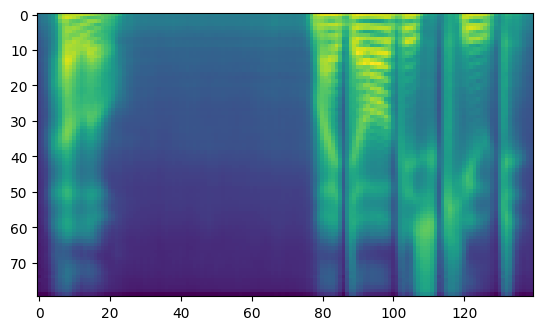

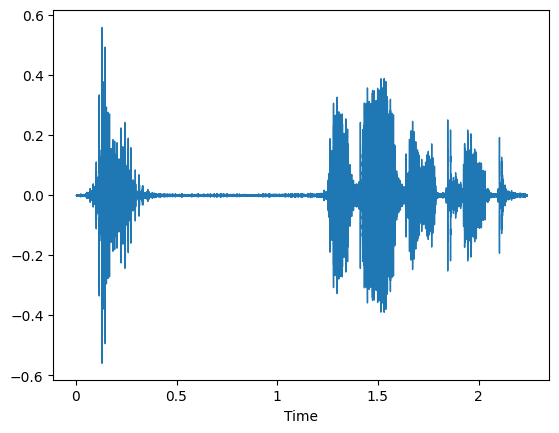

In [25]:
from transformers import SpeechT5Processor, SpeechT5ForTextToSpeech, SpeechT5HifiGan, set_seed
from IPython.display import Audio
from datasets import load_dataset
import soundfile as sf
import librosa
import torch

set_seed(42) # make results deterministic

model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")

inputs = processor(text="Hello, my dog is cute", return_tensors="pt")
speaker_embeddings = torch.zeros((1, 512))

# You can optionally use "speaker embeddings" to customize the output to a particular speaker’s voice characteristics
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[42]["xvector"]).unsqueeze(0)

spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
with torch.no_grad(): speech = vocoder(spectrogram)

# You can plot the generated spectrogram
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(spectrogram.T)
plt.show()

librosa.display.waveshow(speech.numpy(), sr=16000) # You can plot the generated waveform
sf.write("tts_example.wav", speech.numpy(), samplerate=16000) # You can save the audio to a .wav file
display(Audio(speech.numpy(), rate=16000)) # You can hear the audio inputs

## Intermediate tasks:

* Connect the results from your answer to the previous intermediate task (i.e., conditioned language generation) to the SpeechT5 text-to-speech model, so as to produce speech outputs from the text generated by the model.
* Produce speech-based answers for the first 5 questions in the validation split from the SQuaD dataset.
* Connect also the results from your answer to the first intermediate task (i.e., automated speech recognition) to the SpeechT5 model and the LLM, so as to take spoken questions as input and produce a speech output.
* Collect small audio samples, with your own voice, for the first 5 questions in the validation split from the SQuaD dataset, and produce speech-based answers for these five questions.


Denver Broncos


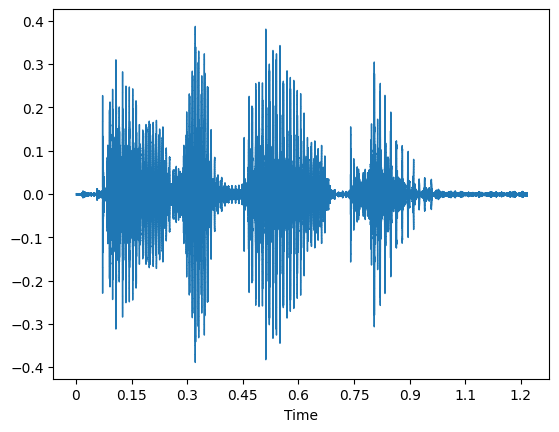

In [30]:
predictions_5=predictions_val1000[:5]
print(predictions_5[0])

inputs = processor(text=predictions_5[0], return_tensors="pt")
speaker_embeddings = torch.zeros((1, 512))
embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")
speaker_embeddings = torch.tensor(embeddings_dataset[42]["xvector"]).unsqueeze(0)

spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
with torch.no_grad(): speech = vocoder(spectrogram)
librosa.display.waveshow(speech.numpy(), sr=16000) # You can plot the generated waveform
predictions_5=predictions_val1000[:5]

for pred in predictions_5:
  print(pred)
  inputs = processor(text=pred, return_tensors="pt")
  speaker_embeddings = torch.zeros((1, 512))
  speaker_embeddings = torch.tensor(embeddings_dataset[42]["xvector"]).unsqueeze(0)

  spectrogram = model.generate_speech(inputs["input_ids"], speaker_embeddings)
  with torch.no_grad(): speech = vocoder(spectrogram)
  display(Audio(speech.numpy(), rate=16000))


In [50]:

#--------------------------------------------------------------------------------
def text2speech(text_set):
  text2speech_model = SpeechT5ForTextToSpeech.from_pretrained("microsoft/speecht5_tts")
  vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
  processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_tts")
  embeddings_dataset = load_dataset("Matthijs/cmu-arctic-xvectors", split="validation")

  for pred in text_set:
    inputs = processor(text=pred, return_tensors="pt")
    speaker_embeddings = torch.zeros((1, 512))
    speaker_embeddings = torch.tensor(embeddings_dataset[42]["xvector"]).unsqueeze(0)

    spectrogram = text2speech_model.generate_speech(inputs["input_ids"], speaker_embeddings)
    with torch.no_grad(): speech = vocoder(spectrogram)
    display(Audio(speech.numpy(), rate=16000))
  return speech

def text2text(text_set,context): #receives text, whether context is available and returns predictions
  if context==False:
    x_prompt=[' Answer with less than 10 words. Question: '+ x for x in text_set]
  else:
    x_prompt=[context+' Answer with less than 10 words. Question: '+ x for x in text_set]
  mt0=pipeline(model="bigscience/mt0-small")
  prediction=mt0(x_prompt,max_length=25)
  prediction=[d['generated_text'] for d in prediction]
  return prediction

In [37]:
def dialogue_system(audio):
  if len(audio[0])==1:
    print('Make sure input is a list of numpy arrays')
    return
  question_transcript=speech2text(audio)
  print(question_transcript)
  answer=text2text(question_transcript,False)
  print(answer)
  answer_utt=text2speech(answer)
  return answer
dialogue_system([question_1]) #Returned answer: Gerald Ford

In [40]:
audios=[]
for i in range(1,5):
  audios.append(np.squeeze(librosa.load('squad_{}.m4a'.format(i)))[0])
set_seed(42)

dialogue_system(audios)

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (448) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[' which NFL team represented the AFC at Super Bowl 50.', ' which NFL team represented the NFC at Super Bowl 15.', ' Where did Super Bowl 50 take place?', ' which NFL team won the Super Bowl 15.']


Some weights of MT5ForConditionalGeneration were not initialized from the model checkpoint at bigscience/mt0-small and are newly initialized: ['decoder.embed_tokens.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


['NFL', 'NFL', 'Cincinnati', 'NFL']


['NFL', 'NFL', 'Cincinnati', 'NFL']

# Main problem

Students are tasked with joining together the speech recognition, language understanding and generation, and text-to-speech models, in order to build a conversational spoken question answering approach.

* The method should take as input speech utterances with questions.
* The language understanding and generation component should use as input a transcription for the current speech utterance, and optionally also transcriptions from previous speech utterances (i.e., the conversation context).
* The language understanding and generation component can explore different strategies for improving answer quality:
  * Use of large LLMs trained with reinforcement learning from human feedback.
  * Prompting the language model with retrieved in-context examples.
  * Using parameter-efficient fine-ting with existing conversational question answering datasets (e.g., [the CoQA dataset](https://stanfordnlp.github.io/coqa/), available from HuggingFace datasets).
  * ...
* The text-to-speech component takes as input the results from language generation, and produces a speech output.
* Both the automated speech recognition and the text-to-speech components can explore different approaches, although students should attempt to justify their choices (e.g., if changing the automated speech recognition component, show that it achieves a lower WER).
* Collect small audio samples, with your own voice, for the first two instances in the CoQA validation split, and show the results produced by your method for these examples.

In [42]:
coqa_builder = load_dataset_builder("coqa")
print(coqa_builder.info.description)

coqa_train = load_dataset("coqa", split="train")
coqa_val = load_dataset("coqa", split="validation")


CoQA: A Conversational Question Answering Challenge



Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7199 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/500 [00:00<?, ? examples/s]

Dataset coqa downloaded and prepared to /root/.cache/huggingface/datasets/coqa/default/1.0.0/1b03a32914e882ed315577005c472665e542419f910bab445815ad1929a7958f. Subsequent calls will reuse this data.


In [49]:
coqa_val[0]

{'source': 'mctest',
 'story': 'Once upon a time, in a barn near a farm house, there lived a little white kitten named Cotton. Cotton lived high up in a nice warm place above the barn where all of the farmer\'s horses slept. But Cotton wasn\'t alone in her little home above the barn, oh no. She shared her hay bed with her mommy and 5 other sisters. All of her sisters were cute and fluffy, like Cotton. But she was the only white one in the bunch. The rest of her sisters were all orange with beautiful white tiger stripes like Cotton\'s mommy. Being different made Cotton quite sad. She often wished she looked like the rest of her family. So one day, when Cotton found a can of the old farmer\'s orange paint, she used it to paint herself like them. When her mommy and sisters found her they started laughing. \n\n"What are you doing, Cotton?!" \n\n"I only wanted to be more like you". \n\nCotton\'s mommy rubbed her face on Cotton\'s and said "Oh Cotton, but your fur is so pretty and special, l

In [65]:
def dialogue_system_coqa(question,context):
  """This is supposed to work in a loop: give on question,
  get response, and new context will
  contain prev context+question+anwer"""
  question_transcript=speech2text([question])
  answer=text2text(question_transcript,context)
  answer_utt=text2speech(answer)
  return context+' \n '+question_transcript[0]+' \n'+answer[0]

context_1=coqa_val[0]['story']


for i in range(1,3):
  context_1=dialogue_system_coqa(np.squeeze(librosa.load('coqa_{}.m4a'.format(i)))[0],context_1)

<ipython-input-65-39771d79cb16>:14: UserWarning: PySoundFile failed. Trying audioread instead.
  context_1=dialogue_system_coqa(np.squeeze(librosa.load('coqa_{}.m4a'.format(i)))[0],context_1)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (448) to control the gener

<ipython-input-65-39771d79cb16>:14: UserWarning: PySoundFile failed. Trying audioread instead.
  context_1=dialogue_system_coqa(np.squeeze(librosa.load('coqa_{}.m4a'.format(i)))[0],context_1)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (448) to control the gener

In [66]:
#We can use the same pipeline without giving an initial context:
context_2=''
for i in range(1,3):
  context_2=dialogue_system_coqa(np.squeeze(librosa.load('coqa_{}.m4a'.format(i)))[0],context_2)

<ipython-input-66-8a347ac14f95>:4: UserWarning: PySoundFile failed. Trying audioread instead.
  context_2=dialogue_system_coqa(np.squeeze(librosa.load('coqa_{}.m4a'.format(i)))[0],context_2)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (448) to control the genera

<ipython-input-66-8a347ac14f95>:4: UserWarning: PySoundFile failed. Trying audioread instead.
  context_2=dialogue_system_coqa(np.squeeze(librosa.load('coqa_{}.m4a'.format(i)))[0],context_2)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1353: UserWarning: Using `max_length`'s default (448) to control the genera